# 1 - install dependencies

In [1]:
import numpy as np
import cv2 
import os
import mediapipe as mp
import tensorflow as tf 
from tensorflow import keras
import matplotlib.pyplot as plt
import time
import pandas as pd

# 2 - keypoints extractions and drawing

In [2]:
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

num_hand_marks = 21
num_pose_marks = 33


# holistic model process image and return the results as keypoints
def mediapipe_detection(image,model):
    image  = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = model.process(image)
    image.flags.writeable = True
    image  = cv2.cvtColor(image,cv2.COLOR_RGB2BGR)
    return image,results
    
def draw_styled_landmarks(image,results):
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 
    

# read the keypoints and extract them and process them
def extract_keypoints(results):
    # extract pose marks
    if results.pose_landmarks:
        pose = np.array([ [res.x,res.y,res.z,res.visibility] for res in results.pose_landmarks.landmark ]).flatten()
    else:
        pose = np.zeros(num_pose_marks*4)
    
    # extract left hand
    if results.left_hand_landmarks:
        left_hand = np.array([ [res.x,res.y,res.z] for res in results.left_hand_landmarks.landmark ]).flatten()
    else:
        left_hand = np.zeros(num_hand_marks*3)
        
        
    # extract right hand
    if results.right_hand_landmarks:
        right_hand = np.array([ [res.x,res.y,res.z] for res in results.right_hand_landmarks.landmark ]).flatten()
    else:
        right_hand = np.zeros(num_hand_marks*3)
    
    return np.concatenate([pose,left_hand,right_hand])
    

# 3 - read and process data

In [3]:
data_path = "../../../data/Datasets/"

train_labels = pd.read_csv(os.path.join(data_path,"train_labels.csv"),names=['sample','id'])
validation_labels = pd.read_csv(os.path.join(data_path,"validation_labels.csv"),names=['sample','id'])
test_labels = pd.read_csv(os.path.join(data_path,"test_labels.csv"),names=['sample','id'])
class_id = pd.read_csv(os.path.join(data_path,"class_id.csv"))


    
train_path = os.path.join(data_path,"train")
val_path = os.path.join(data_path,"val")
test_path = os.path.join(data_path,"test")



In [4]:
def check_file(file_path):
    try:
        f = open(file_path)
        f.close()
        return True
    except IOError:
        return False
    
    

def construct_path(file,path="train"):
    return os.path.join(os.path.join(data_path,path),file+"_color.mp4")
    

### 3.1 collect data that in classes 0,1,2 and available in the data/train directory

In [5]:
n_actions = 20
actions = list(class_id['EN'][:n_actions])
dic={}
for i,action in enumerate(actions):
    dic[action]=i

In [6]:
def get_data(id,file_path):
    if file_path=="train":
        label_dic = train_labels
    elif file_path=="val":
        label_dic = validation_labels
    elif file_path=="test":
        label_dic = test_labels
        
    
    data =  label_dic[label_dic['id']==id]
    lis =  [construct_path(i,file_path) for i in  (data['sample'])]
    data =  [i for i in lis if check_file(i)]
    return data,[id for i in data]
    

    

In [7]:


train_X = [] 
train_Y = []
val_X = [] 
val_Y = []
test_X = [] 
test_Y = []

for i in range(n_actions):
    data,labels = get_data(i,'train')
    train_X.extend(data)
    train_Y.extend(labels)

    
for i in range(n_actions):
    data,labels = get_data(i,'val')
    val_X.extend(data)
    val_Y.extend(labels)

    
for i in range(n_actions):
    data,labels = get_data(i,'test')
    test_X.extend(data)
    test_Y.extend(labels)
    

In [8]:
print(
    len(train_X ),
len(train_Y),
len(val_X ),
len(val_Y),
len(test_X ),
len(test_Y)
)

2450 2450 382 382 328 328


### 3.2 process videos into frames and label to cateogries

In [9]:


def capture_frames(video_path):
    video = cv2.VideoCapture(video_path)
    video_length = int(video.get(cv2.CAP_PROP_FRAME_COUNT)) - 1
    # count = 0
    # frame_rate = video.get(cv2.CAP_PROP_FRAME_COUNT)

    count=0
    frames = []
    while video.isOpened():
      # frame_id = video.get(0)
        ret, frame = video.read()
        
        if not ret:
            continue
        frames.append(frame)
        count += 1
        # If there are no more frames left
        if (count > (video_length-1)):
          # Release the feed
          video.release()
        # if frame_id % math.floor(1) == 0:
        #     file_name = f"{video_path}_frame_{count}.jpg"
        #     count += 1
        #     # print(f"File name: {file_name}")
        #     frames.append(frame)
        #     # cv2.imwrite(file_name, frame)
    video.release()
    return np.array(frames)


def get_frames(video_path,num_frames):
    frames = capture_frames(video_path)
    video_length = len(frames)
    steps = video_length/num_frames
    count=0
    new_frames=[]
    while count<video_length:
        frame = frames[int(count)]
#         frame = cv2.resize(frame, (256, 256))
#         frame =  (frame/255.0).astype(np.float16)
        new_frames.append(frame)
        count+=steps

    s = np.array(new_frames[:num_frames])
    print("SHAPE",s.shape)
    return np.array(new_frames[:num_frames])


In [10]:
def extract_keypoints_video(path,i=-1):
    
    if(i!=-1):
        print(i,end="\r")
    
    if(type(path) == str):
        frames = get_frames(path,20)
    frames = path
    output_key_points=[]
    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
        for frame in frames:
            image, results = mediapipe_detection(frame, holistic)
            output_key_points.append(extract_keypoints(results))
    return np.array(output_key_points)
    

### 3.3 - extract the keypoints and save them in train

In [11]:
if "train_features:0-20.npy" in os.listdir():
    train_data = np.load("train_features:0-20.npy")
    val_data = np.load("val_features:0-20.npy")
    test_data = np.load("test_features:0-20.npy")
    train_labels = np.load("train_labels:0-20.npy")
    val_labels = np.load("val_labels:0-20.npy")
    test_labels = np.load("test_labels:0-20.npy")
else:
    train = np.array([extract_keypoints_video(path,f'iteration : {i+1}/{len(train_X)}') for i,path in enumerate(train_X) ])
    np.save('train_features:0-20.npy', train) 
    val = np.array([extract_keypoints_video(path,f'iteration : {i+1}/{len(val_X)}') for i,path in enumerate(val_X) ])
    np.save('val_features:0-20.npy', val) 
    test = np.array([extract_keypoints_video(path,f'iteration : {i+1}/{len(test_X)}') for i,path in enumerate(test_X) ])
    np.save('test_features:0-20.npy', test)
    np.save("train_labels:0-20.npy",np.array(train_Y))
    np.save("val_labels:0-20.npy",np.array(val_Y))
    np.save("test_labels:0-20.npy",np.array(test_Y))

In [12]:
print(
train_data.shape,
    train_labels.shape,
    val_data.shape,
    val_labels.shape,
    test_data.shape,
    test_labels.shape
    
)

(2450, 20, 258) (2450,) (382, 20, 258) (382,) (328, 20, 258) (328,)


### 3.4 split the data (training,testing)

In [13]:
perm = np.random.permutation(len(train_data))

train_X = train_data[perm]
train_Y = train_labels[perm]
val_X = val_data
val_Y = val_labels
test_X = test_data
test_Y = test_labels


In [14]:
print(
train_X.shape,
train_Y.shape,
val_X.shape,
val_Y.shape,
test_X.shape,
test_Y.shape,
)

(2450, 20, 258) (2450,) (382, 20, 258) (382,) (328, 20, 258) (328,)


# 4 - build the model

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Input,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard,ModelCheckpoint,EarlyStopping


tb_callback = TensorBoard(log_dir=os.path.join('Logs'))
checkpoint = ModelCheckpoint("best_model.h5", monitor='loss', verbose=0,
    save_best_only=True, mode='auto', save_freq=1)
earlyStopping = EarlyStopping(monitor='loss', patience=20)

In [31]:
def first_model():
    input_layer = Input(shape=(20,258))
    layer = LSTM(64,return_sequences=True,activation="relu")(input_layer)
    layer = LSTM(128,return_sequences=True,activation="relu")(layer)
    layer = LSTM(256,return_sequences=True,activation="relu")(layer)
    layer = LSTM(128,return_sequences=True,activation="relu")(layer)
    layer = LSTM(64,return_sequences=False,activation="relu")(layer)
    layer = Dense(64,activation="relu")(layer)
    layer = Dense(32,activation="relu")(layer)
    layer = Dense(len(actions),activation="softmax")(layer)

    model = Model(inputs=input_layer,outputs=layer)
    model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model


def second_model():
    input_layer = Input(shape=(20,258))
    layer = LSTM(64,return_sequences=True,activation="relu")(input_layer)
    layer = LSTM(128,return_sequences=True,activation="relu")(layer)
    layer = Dropout(0.3)(layer)
    layer = LSTM(128,return_sequences=True,activation="relu")(layer)
    layer = Dropout(0.3)(layer)
    layer = LSTM(64,return_sequences=False,activation="relu")(layer)
    layer = Dense(64,activation="relu")(layer)
    layer = Dense(32,activation="relu")(layer)
    layer = Dense(len(actions),activation="softmax")(layer)

    model = Model(inputs=input_layer,outputs=layer)
    model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['categorical_accuracy'])
    
    return model

def third_model():
    input_layer = Input(shape=(20,258))
    layer = LSTM(64,return_sequences=True,activation="relu")(input_layer)
    layer = LSTM(128,return_sequences=True,activation="relu")(layer)
    layer = LSTM(64,return_sequences=False,activation="relu")(layer)
    layer = Dense(64,activation="relu")(layer)
    layer = Dense(32,activation="relu")(layer)
    layer = Dense(len(actions),activation="softmax")(layer)

    model = Model(inputs=input_layer,outputs=layer)
    model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['categorical_accuracy'])
    
    return model


model = first_model()

In [43]:
model.load_weights('best_model.h5')

In [33]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 20, 258)]         0         
                                                                 
 lstm_15 (LSTM)              (None, 20, 64)            82688     
                                                                 
 lstm_16 (LSTM)              (None, 20, 128)           98816     
                                                                 
 lstm_17 (LSTM)              (None, 20, 256)           394240    
                                                                 
 lstm_18 (LSTM)              (None, 20, 128)           197120    
                                                                 
 lstm_19 (LSTM)              (None, 64)                49408     
                                                                 
 dense_9 (Dense)             (None, 64)                4160

In [30]:
train_Y[0:40]

array([14, 18,  0, 10, 13, 19,  9, 15,  3, 17,  6,  9, 12, 16,  6,  5, 13,
       19, 12, 15, 13,  1,  9,  0, 16,  8, 15,  2, 14,  5,  6,  9,  3, 16,
        1,  1, 15,  4,  1, 11])

In [34]:
history = model.fit(train_X, train_Y, epochs=100, callbacks=[tb_callback,checkpoint,earlyStopping],validation_data=(val_X,val_Y))

Epoch 1/100
77/77 [==============================] - 9s 85ms/step - loss: 2.4501 - accuracy: 0.1114 - val_loss: 2.4617 - val_accuracy: 0.1021
Epoch 2/100
77/77 [==============================] - 6s 78ms/step - loss: 2.4187 - accuracy: 0.1037 - val_loss: 2.4525 - val_accuracy: 0.1204
Epoch 3/100
77/77 [==============================] - 6s 78ms/step - loss: 2.3710 - accuracy: 0.1073 - val_loss: 2.4300 - val_accuracy: 0.1335
Epoch 4/100
77/77 [==============================] - 6s 78ms/step - loss: 2.3565 - accuracy: 0.1171 - val_loss: 2.3534 - val_accuracy: 0.1754
Epoch 5/100
77/77 [==============================] - 6s 77ms/step - loss: 2.2904 - accuracy: 0.1376 - val_loss: 2.2291 - val_accuracy: 0.1754
Epoch 6/100
77/77 [==============================] - 7s 92ms/step - loss: 2.1861 - accuracy: 0.1722 - val_loss: 2.2356 - val_accuracy: 0.1754
Epoch 7/100
77/77 [==============================] - 6s 80ms/step - loss: 2.2433 - accuracy: 0.1735 - val_loss: 2.1033 - val_accuracy: 0.2094
Epoch 

77/77 [==============================] - 6s 78ms/step - loss: 0.5912 - accuracy: 0.7600 - val_loss: 1.1598 - val_accuracy: 0.6466
Epoch 59/100
77/77 [==============================] - 6s 77ms/step - loss: 0.5894 - accuracy: 0.7624 - val_loss: 1.3582 - val_accuracy: 0.5733
Epoch 60/100
77/77 [==============================] - 6s 78ms/step - loss: 0.6250 - accuracy: 0.7555 - val_loss: 1.3928 - val_accuracy: 0.5995
Epoch 61/100
77/77 [==============================] - 10s 130ms/step - loss: 0.7356 - accuracy: 0.7229 - val_loss: 1.1614 - val_accuracy: 0.6518
Epoch 62/100
77/77 [==============================] - 18s 235ms/step - loss: 0.6382 - accuracy: 0.7327 - val_loss: 1.2551 - val_accuracy: 0.6597
Epoch 63/100
77/77 [==============================] - 17s 223ms/step - loss: 0.5324 - accuracy: 0.7812 - val_loss: 1.3139 - val_accuracy: 0.6178
Epoch 64/100
77/77 [==============================] - 18s 233ms/step - loss: 0.4520 - accuracy: 0.8122 - val_loss: 1.2684 - val_accuracy: 0.6492
Epoc

In [35]:
history2 = model.fit(train_X, train_Y, epochs=100, callbacks=[tb_callback,checkpoint,earlyStopping],validation_data=(val_X,val_Y))

Epoch 1/100
77/77 [==============================] - 6s 79ms/step - loss: 0.3114 - accuracy: 0.8792 - val_loss: 1.2101 - val_accuracy: 0.7251
Epoch 2/100
77/77 [==============================] - 6s 78ms/step - loss: 0.3184 - accuracy: 0.8857 - val_loss: 1.4796 - val_accuracy: 0.6361
Epoch 3/100
77/77 [==============================] - 6s 77ms/step - loss: 0.2862 - accuracy: 0.8967 - val_loss: 1.6445 - val_accuracy: 0.6178
Epoch 4/100
77/77 [==============================] - 6s 77ms/step - loss: 0.3504 - accuracy: 0.8804 - val_loss: 0.9460 - val_accuracy: 0.7173
Epoch 5/100
77/77 [==============================] - 6s 77ms/step - loss: 0.2472 - accuracy: 0.9041 - val_loss: 1.2549 - val_accuracy: 0.7094
Epoch 6/100
77/77 [==============================] - 6s 79ms/step - loss: 0.2328 - accuracy: 0.9069 - val_loss: 1.3645 - val_accuracy: 0.6571
Epoch 7/100
77/77 [==============================] - 6s 78ms/step - loss: 0.2509 - accuracy: 0.9037 - val_loss: 1.1070 - val_accuracy: 0.7251
Epoch 

Epoch 58/100
77/77 [==============================] - 19s 248ms/step - loss: 0.1555 - accuracy: 0.9502 - val_loss: 1.4496 - val_accuracy: 0.7304
Epoch 59/100
77/77 [==============================] - 17s 227ms/step - loss: 0.2178 - accuracy: 0.9286 - val_loss: 1.0468 - val_accuracy: 0.7356
Epoch 60/100
77/77 [==============================] - 17s 223ms/step - loss: 0.1028 - accuracy: 0.9637 - val_loss: 1.1939 - val_accuracy: 0.7173
Epoch 61/100
77/77 [==============================] - 17s 227ms/step - loss: 0.1357 - accuracy: 0.9486 - val_loss: 1.1246 - val_accuracy: 0.7644
Epoch 62/100
77/77 [==============================] - 17s 223ms/step - loss: 0.2099 - accuracy: 0.9257 - val_loss: 1.3463 - val_accuracy: 0.7042
Epoch 63/100
77/77 [==============================] - 12s 161ms/step - loss: 0.1405 - accuracy: 0.9502 - val_loss: 1.4930 - val_accuracy: 0.7016
Epoch 64/100
77/77 [==============================] - 6s 81ms/step - loss: 0.1804 - accuracy: 0.9453 - val_loss: 1.1054 - val_accu

In [151]:
print(history.history.keys())
# summarize history for accuracy



dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


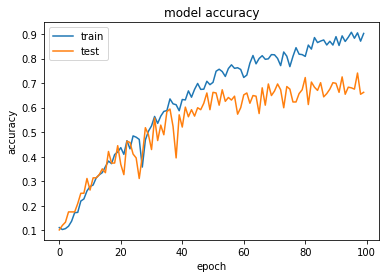

In [40]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

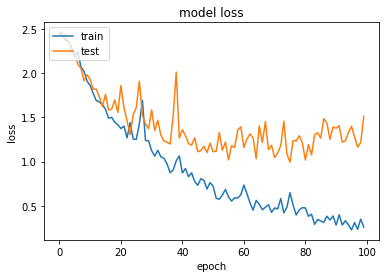

In [41]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

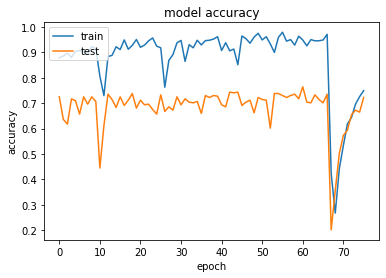

In [38]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

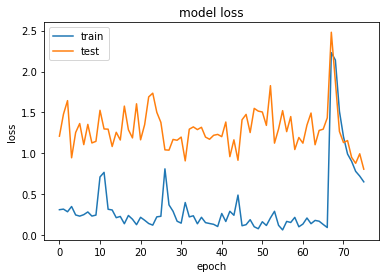

In [39]:
# summarize history for loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [45]:
model.evaluate(train_X,train_Y)

77/77 [==============================] - 1s 11ms/step - loss: 0.0624 - accuracy: 0.9784


[0.06242760643362999, 0.9783673286437988]

In [46]:
model.evaluate(val_X,val_Y)

12/12 [==============================] - 0s 11ms/step - loss: 1.5501 - accuracy: 0.7225


[1.5500975847244263, 0.7225130796432495]

In [47]:
model.evaluate(test_X,test_Y)

11/11 [==============================] - 0s 11ms/step - loss: 1.8379 - accuracy: 0.6921


[1.8378571271896362, 0.6920731663703918]

# 5 - test in real time

In [113]:
from scipy import stats

colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num%3], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame


In [114]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()
        if(not ret):
            break
#         frame = cv2.resize(frame, (512, 512))

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-20:]
        
        if len(sequence) == 20:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-2:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [60]:
cap.release()

In [61]:
cv2.destroyAllWindows()

# 6-read video and predict it (for slower models)

In [54]:
def read_video_camera(n_frames,duration=3):
    import time
    
    frames = []
    
    cap = cv2.VideoCapture(0)
    start_time = time.time()
    while cap.isOpened():
        ret, frame = cap.read()
        if(not ret):break
        
        cv2.imshow("frame",frame)
        
        cv2.waitKey(20)
            
        frames.append(frame)
        if(time.time()-start_time > duration):
            break
    cap.release()
    cv2.destroyAllWindows()
    print(len(frames),n_frames)
    steps = len(frames)/n_frames
    count=0
    new_frames=[]
    while count < len(frames):
        frame = frames[int(count)]
        new_frames.append(frame)
        count+=steps
        
    
    return np.array(new_frames[:n_frames])
    
    
def view_video(video):
    for frame in video:
        cv2.imshow("frame",frame)
        cv2.waitKey(100)
    cv2.destroyAllWindows()
    
    
    

        


In [133]:
video = read_video_camera(n_frames=20,duration=2.5)

59 20


In [134]:
# view_video(video)

In [135]:
key_points = extract_keypoints_video(video)

In [136]:
predection_array = model.predict(np.expand_dims(key_points, axis=0))[0]
predection_id = np.argmax(predection_array)
predection_label = actions[predection_id]
predection_prob = predection_array[predection_id]
print(predection_label,predection_prob)


kin 0.93491805


In [137]:
predection_array

array([2.0466612e-06, 5.3695557e-03, 8.1069311e-06, 1.5126204e-04,
       1.1117121e-03, 2.3179945e-04, 6.4867456e-03, 1.8684345e-07,
       2.8425963e-03, 2.2387251e-08, 7.2930800e-07, 9.3491805e-01,
       3.8555641e-02, 8.9185527e-03, 4.9083933e-06, 6.5342995e-04,
       2.2316642e-07, 7.1633747e-04, 8.9228906e-06, 1.9149189e-05],
      dtype=float32)

In [59]:
actions

['sister',
 'hurry',
 'hungry',
 'enjoy_your_meal',
 'brother',
 'tree',
 'heavy',
 'cry',
 'family',
 'wise',
 'unwise',
 'kin',
 'shopping',
 'key',
 'mother',
 'friend',
 'ataturk',
 'shoe',
 'mirror',
 'same']

In [ ]:
cap.release()


In [ ]:
cv2.destroyAllWindows()

In [53]:
cv2.destroyAllWindows()

# first time results 
### training accuracy -> 97%
### validation accuracy -> 76%


# second time results
### training accuracy -> 75%
### validation accuracy -> 65% and after a while it went down very fast


# third time results
### training accuracy ->  
### validation accuracy -> 52 %